In [15]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial import Polynomial
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow import keras
from tensorflow.keras import layers

from nils.reconstruction_module import cleanup_formfactor
from nils.simulate_spectrometer_signal import get_crisp_signal

## Load and Preprocess Data

In [3]:
with open("ocelot80k.pkl", "rb") as file:
    data = pickle.load(file)

In [4]:
currents = [(sample["s"][:1000], sample["I"][:1000]) for sample in data]
del data

In [5]:
# Only keep samples with current profiles that exceed 1 kA
filtered = [(s, current) for s, current in currents if current.max() > 1000]
len(filtered)

20335

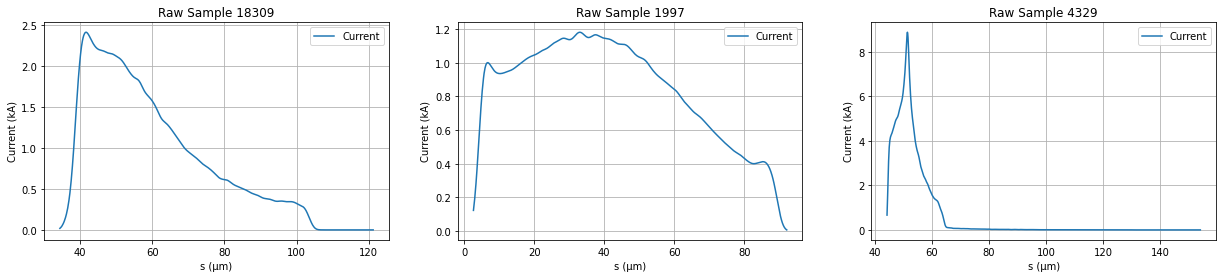

In [6]:
samples = np.random.randint(0, len(filtered), size=3)

plt.figure(figsize=(21,4))
for i, sample in enumerate(samples):
    s = filtered[sample][0]
    current = filtered[sample][1]
    
    plt.subplot(1, 3, i+1)
    plt.title(f"Raw Sample {sample}")
    plt.plot(s*1e6, current*1e-3, label="Current")
    plt.xlabel("s (μm)")
    plt.ylabel("Current (kA)")
    plt.legend()
    plt.grid()
plt.show()

In [7]:
# Shift center of mass of each current profile onto the origin

def shift_onto_center_of_mass(s, current):
    """Shift a current profile such that its center of mass it at 0."""
    cm = (s * current).sum() / current.sum()
    return s - cm, current

shifted = [shift_onto_center_of_mass(s, current) for s, current in filtered]

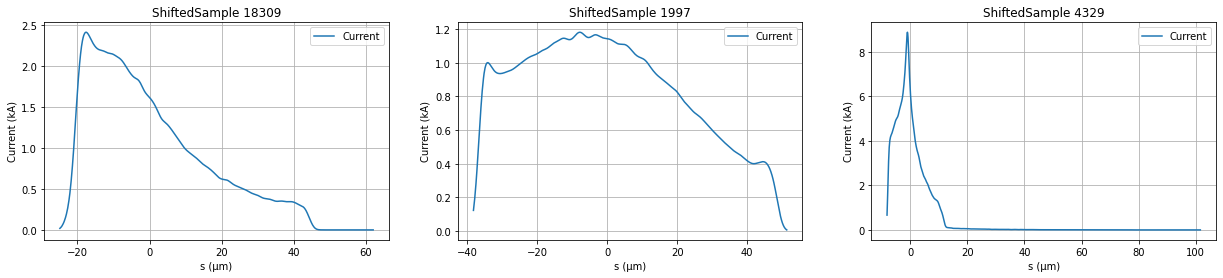

In [8]:
plt.figure(figsize=(21,4))
for i, sample in enumerate(samples):
    s = shifted[sample][0]
    current = shifted[sample][1]
    
    plt.subplot(1, 3, i+1)
    plt.title(f"ShiftedSample {sample}")
    plt.plot(s*1e6, current*1e-3, label="Current")
    plt.xlabel("s (μm)")
    plt.ylabel("Current (kA)")
    plt.legend()
    plt.grid()
plt.show()

In [9]:
polynomials = [Polynomial.fit(*current, deg=30) for current in shifted]

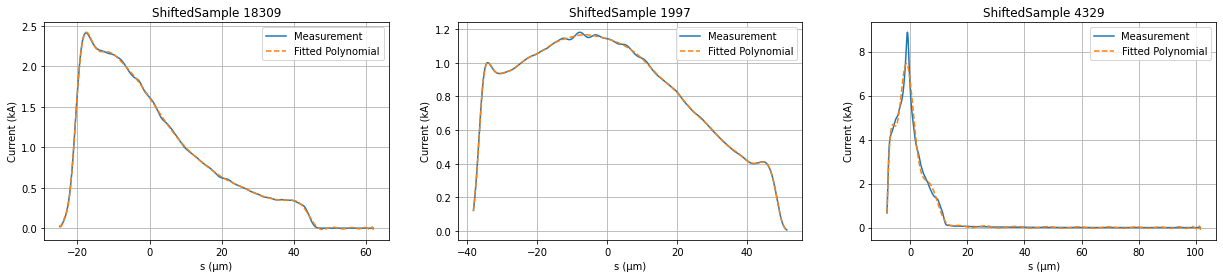

In [10]:
# Fit polynomial to each profile

plt.figure(figsize=(21,4))
for i, sample in enumerate(samples):
    s = shifted[sample][0]
    current = shifted[sample][1]
    poly = polynomials[sample]
    
    plt.subplot(1, 3, i+1)
    plt.title(f"ShiftedSample {sample}")
    plt.plot(s*1e6, current*1e-3, label="Measurement")
    plt.plot(s*1e6, poly(s)*1e-3, ls="--", label="Fitted Polynomial")
    plt.xlabel("s (μm)")
    plt.ylabel("Current (kA)")
    plt.legend()
    plt.grid()
plt.show()

In [11]:
# Make formfactors
def current2formfactor(s, current):
    """Convert a current to its corresponding cleaned form factor."""
    frequency, formfactor, formfactor_noise, detlim = get_crisp_signal(s, current, n_shots=10, which_set="both")
    clean_frequency, clean_formfactor, _ = cleanup_formfactor(frequency, formfactor, formfactor_noise, detlim, channels_to_remove=[])

    return clean_frequency, clean_formfactor

formfactors = [current2formfactor(*current) for current in shifted]

/usr/local/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [12]:
X = np.stack([formfactor for _, formfactor in formfactors])
y = np.stack([poly.coef for poly in polynomials])

## Training

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [16]:
X_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(X_train)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)

In [27]:
model = keras.Sequential([
    layers.Dense(200, activation="relu"),
    layers.Dense(100, activation="relu"),
    layers.Dense(50, activation="relu"),
    layers.Dense(y_train.shape[1], activation="relu")]
)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [28]:
history = model.fit(X_train_scaled, y_train_scaled, epochs=80, batch_size=64, validation_split=0.25, verbose=0)

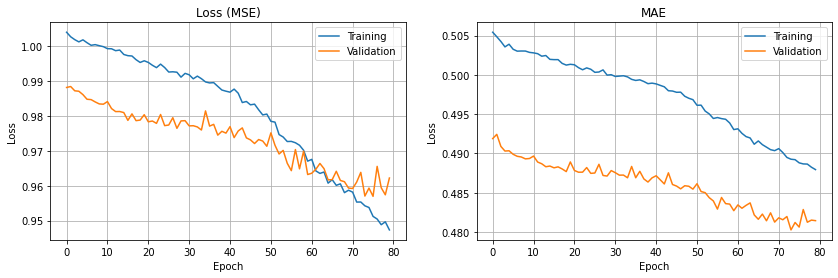

In [29]:
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.title("Loss (MSE)")
plt.plot(history.history["loss"], label="Training")
plt.plot(history.history["val_loss"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.subplot(122)
plt.title("MAE")
plt.plot(history.history["mae"], label="Training")
plt.plot(history.history["val_mae"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

## Quick Test

In [30]:
X_test_scaled = X_scaler.transform(X_test)
y_predict_scaled = model.predict(X_test_scaled)
y_predict = y_scaler.inverse_transform(y_predict_scaled)

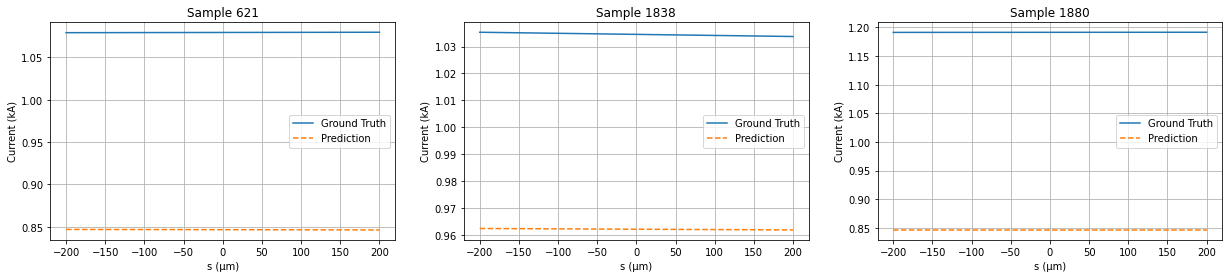

In [31]:
samples = np.random.randint(0, len(y_predict), size=3)

plt.figure(figsize=(21,4))
for i, sample in enumerate(samples):
    s = np.linspace(-200e-6, 200e-6, 1000)
    truth = Polynomial(y_test[sample])
    prediction = Polynomial(y_predict[sample])
    
    plt.subplot(1, 3, i+1)
    plt.title(f"Sample {sample}")
    plt.plot(s*1e6, truth(s)*1e-3, label="Ground Truth")
    plt.plot(s*1e6, prediction(s)*1e-3, ls="--", label="Prediction")
    plt.xlabel("s (μm)")
    plt.ylabel("Current (kA)")
    plt.legend()
    plt.grid()
plt.show()

## Evaluation

In [32]:
X_test_scaled = X_scaler.transform(X_test)
y_test_scaled = y_scaler.transform(y_test)

In [33]:
score = model.evaluate(X_test_scaled, y_test_scaled, batch_size=64)

64/64 [==============================] - 0s 2ms/step - loss: 0.9810 - mae: 0.4965
